In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


class NeuralNet(nn.Module):
    def __init__(self, layers):
        super(NeuralNet, self).__init__()
        self.layers = layers
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 2)]
        )
        self.output_layer = nn.Linear(layers[-2], layers[-1])

    def forward(self, r):
        x = r
        for hidden_layer in self.hidden_layers:
            x = F.tanh(hidden_layer(x))
        y = self.output_layer(x)
        return y


class MHPINN(nn.Module):
    def __init__(self, head_nums, layers, L, D, a, d, r_s_f, r_s_phi_b, z_p_s):
        super(MHPINN, self).__init__()
        self.head_nums = head_nums
        self.neural_nets = nn.ModuleList(
            [NeuralNet(layers).to(device) for _ in range(self.head_nums)]
        )
        self.end_net = NeuralNet([layers[-1] * head_nums, 1]).to(device)
        self.L = L
        self.D = D
        self.a = a
        self.d = d
        self.r_s_f = r_s_f
        self.r_s_phi_b = r_s_phi_b
        self.z_p_s = z_p_s
        self.losses = []
        self.losses_r = []
        self.losses_bc1 = []
        self.losses_bc2 = []

    def forward(self, r):
        y = torch.cat([net(r) for net in self.neural_nets], dim=1)
        y = self.end_net(y)
        return y

    def f(self, r):
        phi = self.forward(r)
        phi_r = torch.autograd.grad(phi.sum(), r, create_graph=True)[0][:, 0].reshape(
            phi.shape
        )
        phi_rr = torch.autograd.grad(phi_r.sum(), r, create_graph=True)[0][
            :, 0
        ].reshape(phi.shape)
        return phi_rr - phi / self.L**2

    def bc(self, r):
        phi = self.forward(r)
        phi_r = torch.autograd.grad(phi.sum(), r, create_graph=True)[0][:, 0].reshape(
            phi.shape
        )
        return -self.D * phi_r - r[:, 1] / 2.0

    def loss_func(self):
        f_pred = self.f(self.r_s_f)
        # bc_pred = self.bc(self.r_b)
        bc_pred = self.forward(self.r_s_phi_b[:, :2])
        self.loss_r = torch.mean(torch.square(f_pred))
        self.loss_bc1 = torch.mean(torch.square(bc_pred - self.r_s_phi_b[:, 2]))
        self.loss_bc2 = torch.mean(torch.square(self.forward(self.z_p_s)))
        self.loss = self.loss_r + self.loss_bc1 + self.loss_bc2
        return self.loss

    def predict(self, r):
        phi = self.forward(r)
        # phi_r = torch.autograd.grad(phi.sum(), r, create_graph=True)[0]
        return phi.detach().cpu().numpy()  # , phi_r.detach().cpu().numpy()


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "/home/ray/code/test/PDE/PINN_BTE/1dBoundPlane/MH-PINN-P/runs/run_6"
model = torch.load("%s/model.pth" % (path))

In [5]:
params = []
for param in model.parameters():
    params.append(param.detach().cpu().numpy())

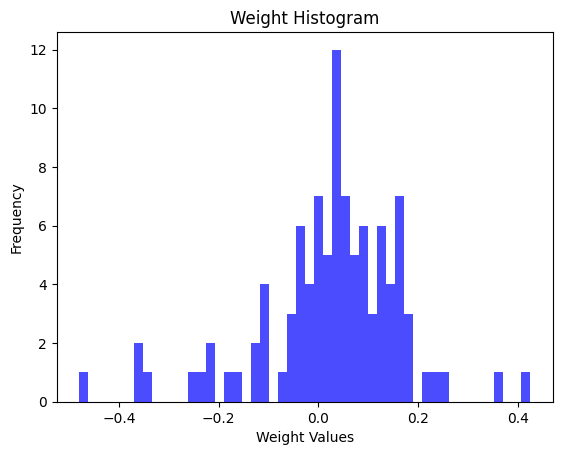

In [12]:
visual = params[-4][0]
# 绘制权重直方图
plt.hist(visual, bins=50, color='blue', alpha=0.7)
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.title('Weight Histogram')
plt.show()

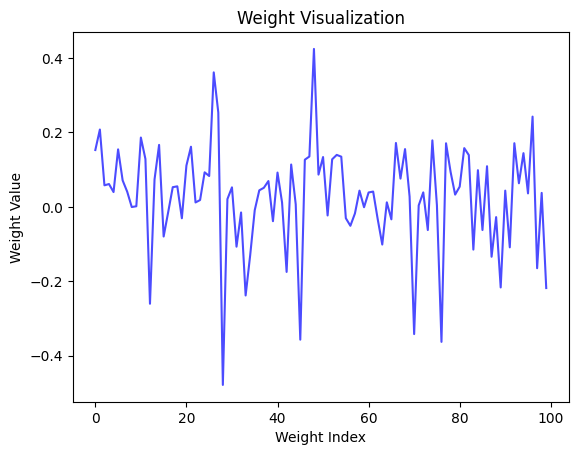

In [13]:
plt.plot(visual, color='blue', alpha=0.7)
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.title('Weight Visualization')
plt.show()